In [1]:
# THIS CODE TAKES IMAGES WITH 3D RANDOM ELLIPSOIDS AND ADDED NOISE, AT THE MINI-PET SCANNER RESOLUTION 
# IT TRAINS A NETWORK WITH THOSE IMAGES AND USES IT TO DENOISE OTHER RANDOM ELLIPSOIDS IMAGES. 
# THE RESULTS ARE COMPARED TO A 10 ITERATION MLEM RECONSTRUCTION OF THE SAME IMAGES.

# THIS CODE FOLLOWS THE STORED RESULTS OF THE 3D MODEL FROM A PREVIOUS CODE

# IMPORT NECESSARY PACKAGES:

import numpy as np
import odlpet # PET imaging module
import odl # Reconstruction module
import torch # Deep learning package
from torch import nn
from torch.nn import functional as F
from torch import optim # Optimizer package
import torchvision
from torchvision import datasets, transforms # Package to manipulate datasets
import matplotlib.pyplot as plt # Plotting package
torch.manual_seed(123);  # reproducibility
from odlpet.scanner.scanner import Scanner # PET scanner package
from odlpet.scanner.compression import Compression
from odl.contrib.torch import OperatorAsModule # Package to convert ODL operators into PyTorch Tensors
import time 
from odl.contrib import fom # Figures of merit package
from scipy.ndimage import zoom # Downsampling and upsampling operator to save CUDA memory while training the networks

In [2]:
# MINI-PET GEOMETRY: 3D

scanner = Scanner() # Scanner operator

scanner.num_rings = 35 # Number of rings

compression = Compression(scanner) # Compress the scanner

# Select acquisition parameters
compression.max_num_segments = 0 # only direct sinograms
compression.num_of_views = 180 # angle resolution
compression.num_non_arccor_bins = 147 # tangential resolution
compression.data_arc_corrected = True
pet_projector = compression.get_projector(restrict_to_cylindrical_FOV=False) # domain resolution: 35 in z axis, 371 in x,y axis
pet_projector_adj=pet_projector.adjoint

In [3]:
pet_projector_adj=pet_projector.adjoint # Compute adjoint operator
pet_projector.range # Get the range of the PET sinogram space

uniform_discr([   0.,    0., -102.], [  35.    ,    3.1416,  102.    ], (35, 180, 147), dtype='float32')

In [4]:
pet_projector.domain # Get the range of the PET image space

uniform_discr([  0. , -21.9, -21.9], [ 46.575,  22.2  ,  22.2  ], (69, 147, 147), dtype='float32')

In [5]:
# Obtain also the conversion into torch tensors for the forward operator and its adjoint
fwd_op_mod=OperatorAsModule(pet_projector)
fwd_op_adj_mod = OperatorAsModule(pet_projector_adj)

In [6]:
def generate_ellipsoids_3d(space,num=np.random.poisson(30),diag=200):
    # Function for computing volumes with random uncentered 3D ellipsoids
    
    # Generate a 3D phantom of randomly distributed ellipsoids, using for that purpose a "surrounding" space where these ellipsoids are computed and then cropping this "surrounding" space
    # in the center with a size equal to the one given by the reconstruction space. The number of elipsoids is given by "num" and it is usually randomly distributed with a Poisson distribution
    
    max_axis=diag**3 # Maximum length of the long axis of the ellipsis
    
    # Surrounding space:
    surround=odl.uniform_discr([0, 0, 0], [int(np.ceil(diag)),int(np.ceil(diag)),int(np.ceil(diag))], 
                               [int(np.ceil(diag)), int(np.ceil(diag)), int(np.ceil(diag))], dtype='float32') 

    elipse_image=np.zeros((space.shape[0],space.shape[1],space.shape[2])) # Accumulator image with all the valid ellipses
    
    for i in range(num):
        # Propose possible ellipses in a space surrounding the "real PET space". Take into consideration only those ones that fall totally or partially in the "real PET space"
        value=np.random.rand() # Random value for the ellipsis
        phi=np.random.rand()*2*np.pi # 3D angulation for the elipsis
        theta=np.random.rand()*2*np.pi # 3D angulation for the elipsis
        psi=np.random.rand()*2*np.pi # 3D angulation for the elipsis

        if diag>np.max(pet_projector.domain.shape): # The surrounding space has to be larger than our space
            x_center=2*np.random.rand()-1 # X center of elipsis
            y_center=2*np.random.rand()-1 # Y center of elipsis
            z_center=2*np.random.rand()-1 # Z center of elipsis
            axis1=np.random.exponential(scale=.5) # Axis 1 of elipsis
            axis2=np.random.exponential(scale=.5) # Axis 2 of elipsis
            axis3=np.random.exponential(scale=.5) # Axis 3 of elipsis

            elipse=[[value,axis1, axis2, axis3, x_center, y_center, z_center, phi, theta, psi]]

            el=odl.phantom.geometric.ellipsoid_phantom(surround, elipse).asarray() # Candidate elipse in the surrounding space
            
            # Express the patch where the reconstruction space is centered
            central_patch=el[int(np.ceil(diag/2))-int(np.ceil(pet_projector.domain.shape[0]/2)):int(np.ceil(diag/2))+int(np.ceil(pet_projector.domain.shape[0]/2))-1,int(np.ceil(diag/2))-int(np.ceil(pet_projector.domain.shape[1]/2)):int(np.ceil(diag/2))+int(np.ceil(pet_projector.domain.shape[1]/2))-1, int(np.ceil(diag/2))-int(np.ceil(pet_projector.domain.shape[2]/2)):int(np.ceil(diag/2))+int(np.ceil(pet_projector.domain.shape[2]/2))-1]
            s=np.sum(np.ndarray.flatten(central_patch))
            if s>0: # If the sum is larger than 0, the ellipse is accepted and the counter is increased by one unit
                
                # Save results in a final matrix
                elipse_image+=central_patch
        else: # Message print to cover exception
            print('Please introduce a maximum value of the ellipse long axis larger than the size of the reconstruction space in both dimensions')
            break
        
        
    return elipse_image

In [7]:
def ellipse_batch(space, number_of_images,number_of_elipses): # Generate a batch of elipsoid images
  
    images = np.zeros((number_of_images,space.shape[0],space.shape[1],space.shape[2])) # Accumulator array for the ellipsoid images
    
    for i in range(number_of_images): # Go through all the images of the desired batched, with a certain reconstruction space and a certain number of ellipses
        image = np.asarray(generate_ellipsoids_3d(space,number_of_elipses))
        
        images[i,:,:,:]=image # Save in the accumulator
    return images

In [8]:
transformations = transforms.Compose([transforms.ToTensor()]) # Transforms to apply to the dataset

from torch.utils.data.dataset import Dataset

# Build a class to construct a PyTorch dataset with the generated random ellipsoid images

class RandomEllipsoidsNormal3d(Dataset):
    # Provide a dataset of ellipsoid images with normal sizes
    def __init__(self,space,num_ellipsoids,diag,train=True,transforms=None):
        """
        Args:
            space: image space where to obtain the dataset of ellipsoid images
            num: number of random ellipsoids
            diag: size of surrounding space used to compute ellipsoids outside the center of the FOV
            num_imag: number of images generated
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.space = pet_projector.domain # Reconstruction space
        self.num_ellipsoids= np.random.poisson(10) # Number of ellipsoids
        self.diag = diag # Diagonal of the surrounding space
        self.train = train # Indicator of training/validation
        self.transforms = transformations # Transformations to apply to the dataset

    def __getitem__(self,index):
        data=torch.tensor(ellipse_batch(self.space,1,self.num_ellipsoids)) # Generate a batch of ellipses of the specified size
        # Transform image to tensor
        #if self.transforms is not None:
            #img_as_tensor = self.transforms(self.data)
        # Return image and the label
        return data

    def __len__(self):
        if self.train==True:
            return 1500 # Number of training images
        else:
            return 1 # Number of validation images
        

if __name__ == "__main__": # Transformations to apply to the datasets
    transformations = transforms.Compose([transforms.ToTensor()])
    random_ellipsoids = \
        RandomEllipsoidsNormal3d(pet_projector.domain, num_ellipsoids=np.random.poisson(10), diag=200, train=True, transforms=transformations) 
    
    

class RandomEllipsoidsEmpty3d(Dataset):
    # Provide a dataset of empty images
    def __init__(self,space,train=True,transforms=None):
        """
        Args:
            space: image space where to obtain the dataset of ellipsoid images
            num: number of random ellipsoids
            diag: size of surrounding space used to compute ellipsoids outside the center of the FOV
            num_imag: number of images generated
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.space = pet_projector.domain # Reconstruction space
        self.train = train # Indicator of training/validation
        self.transforms = transformations # Transformations to apply to the datasets

    def __getitem__(self,index):
        data=torch.tensor(np.zeros((1,self.space.shape[0],self.space.shape[1],self.space.shape[2]))) # Generate an empty tensor of the mini-PET resolution
        # Transform image to tensor
        #if self.transforms is not None:
            #img_as_tensor = self.transforms(self.data)
        # Return image and the label
        return data

    def __len__(self):
        if self.train==True:
            return 250 # Number of training images
        else:
            return 1  # Number of validation images

        
class RandomEllipsoidsFew3d(Dataset):
    # Provide a dataset with few ellipsoids
    def __init__(self,space,num_ellipsoids,diag,train=True,transforms=None):
        """
        Args:
            space: image space where to obtain the dataset of ellipsoid images
            num: number of random ellipsoids
            diag: size of surrounding space used to compute ellipsoids outside the center of the FOV
            num_imag: number of images generated
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.space = pet_projector.domain # Reconstruction space
        self.num_ellipsoids= np.random.poisson(5) # Number of ellipsoids
        self.diag = diag # Diagonal of the surrounding space
        self.train = train # Indicator of training/validation
        self.transforms = transformations # Transformations to apply to the datasets

    def __getitem__(self,index):
        data=torch.tensor(ellipse_batch(self.space,1,self.num_ellipsoids))
        # Transform image to tensor
        #if self.transforms is not None:
            #img_as_tensor = self.transforms(self.data)
        # Return image and the label
        return data

    def __len__(self):
        if self.train==True:
            return 250 # Number of training images
        else:
            return 1 # Number of validation images


In [9]:
# Load training and validation data

# Transformations to execute
trafo = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Train datasets
dset_train_normal=RandomEllipsoidsNormal3d(pet_projector.domain, num_ellipsoids=np.random.poisson(20), diag=200, train=True,transforms=trafo) # Training dataset with normal ellipsoids
dset_train_empty=RandomEllipsoidsEmpty3d(pet_projector.domain, train=True,transforms=trafo) # Training dataset with empty ellipsoids
dset_train_few=RandomEllipsoidsFew3d(pet_projector.domain, num_ellipsoids=np.random.poisson(10), diag=200, train=True,transforms=trafo) # Training dataset with few ellipsoids

# Merge the different datasets so to get a dataset with a high degree of variability
dset_train=torch.utils.data.ConcatDataset([dset_train_normal,dset_train_empty,dset_train_few]) # Concatenated dataset with the three above

In [10]:
# Validation dataset
dset_test=RandomEllipsoidsNormal3d(pet_projector.domain, num_ellipsoids=np.random.poisson(20), diag=200, train=False,transforms=trafo) # Training dataset with normal ellipsoids

# Load datasets
#normal_loader=torch.utils.data.DataLoader(dset_train_normal, batch_size=1, shuffle=True)
#empty_loader=torch.utils.data.DataLoader(dset_train_empty, batch_size=1, shuffle=True)
#few_loader=torch.utils.data.DataLoader(dset_train_few, batch_size=1, shuffle=True)

In [11]:
# Train and test loaders
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=1, shuffle=True)

In [12]:
# Get a batch of test images and generate test projection data
for i,images in enumerate(test_loader):
    if i == 1:
        break

test_images = images # Test images

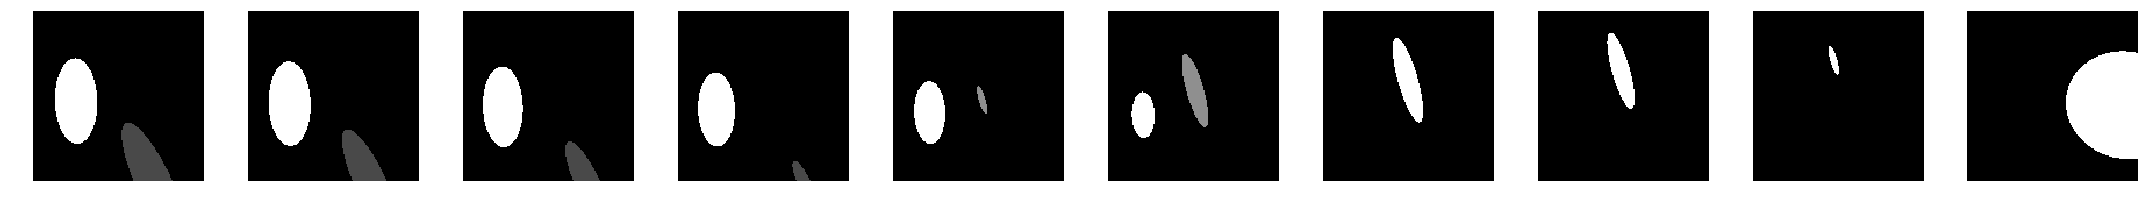

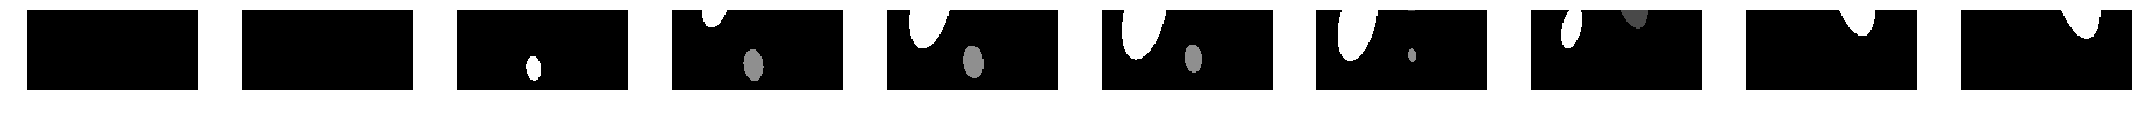

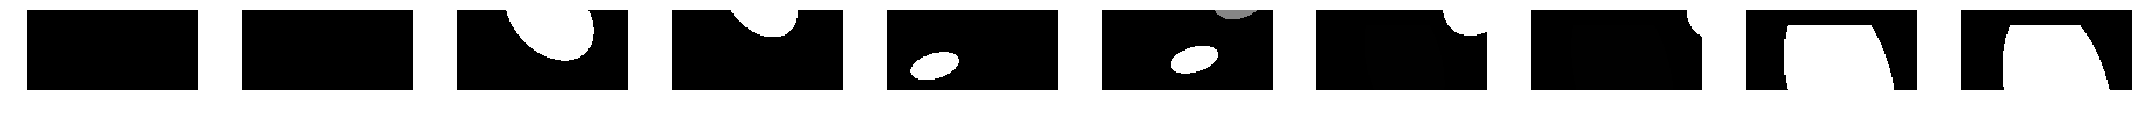

In [13]:
# Fly through images: 3D VISUALIZATION


sz=test_images.cpu().numpy().shape
num=0 # Image index

# Axial views
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=test_images[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal views
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=test_images[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal views
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=test_images[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

In [14]:
# Class for performing MLEM reconstruction
class MLEM(odl.operator.Operator):
    def __init__(self, op, niter):
        super(MLEM, self).__init__(domain=pet_projector.range, range=pet_projector.domain, linear=True) # Define reconstruction space
        self.op = op # Define operator for reconstruction
        self.niter = niter # Define the number of iterations
    
    def _call(self, data):
        reco = self.range.one() # Define the reconstruction space
        odl.solvers.iterative.statistical.mlem(self.op, reco, data, niter=self.niter) # Define the ODL operator for reconstruction in MLEM
        return reco

In [15]:
# MLEM operators for comparison and to introduce in the networks, respectively

mlem_op_comp=MLEM(pet_projector,niter=10) # MLEM operator. 10 iterations
mlem_op_comp_mod=OperatorAsModule(mlem_op_comp) # Modified MLEM operator to work with torch tensors

mlem_op_net=MLEM(pet_projector,niter=1) # MLEM operator. 1 iteration
mlem_op_net_mod=OperatorAsModule(mlem_op_net) # Modified MLEM operator to work with torch tensors

In [16]:
# Define the function to obtain noisy sinograms from the datasets

def generate_data(images, operator, noise_level=1.):
    """Create noisy projection data from images.
    
    The data is generated according to ::
        
        data = Poisson(fwd_op(images)/10)
        
    where ``noise`` is standard white noise.
    
    Parameters
    ----------
    images : `Tensor`, shape ``(B, C, 28, 28)``
        Input images for the data generation.
        
    Returns
    -------
    data : `Tensor`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)
    data = operator(images) # Obtain the forward operator for the given images
    #data += torch.randn(data.shape).type_as(data)
    noisy_data = torch.tensor(np.random.poisson(data.cpu()/noise_level)*noise_level) # Poisson distributed random noise over the data
    # Move data to CPU
    return noisy_data

In [17]:
noise=1/3 # Noise level to introduce in the reconstruction
test_data = generate_data(test_images,fwd_op_mod,noise_level=noise) # Provide noisy test images with Poisson distributed noise

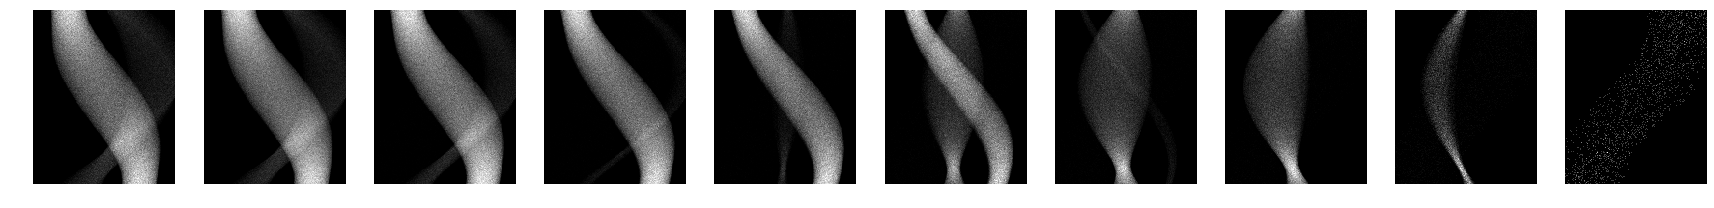

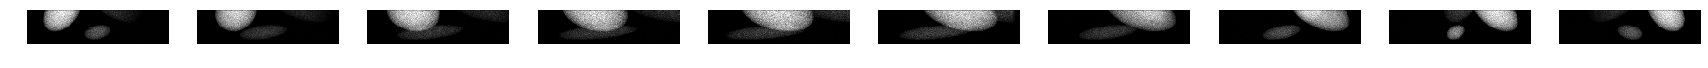

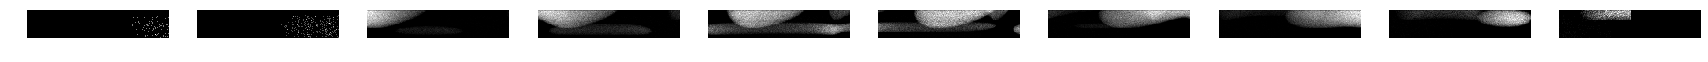

In [18]:
# Sinogram + noise visualization 

num=0 # Image index

# Define sinogram size, dependent on PET acquisition parameters
sz_sino=test_data.cpu().numpy().shape

# Axial views
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,50))
slice_indexes=np.linspace(0,sz_sino[2]-1,10).astype(int)
cont=0
for ind in slice_indexes:
    axial_slice=test_data[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

# Coronal views
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,50))
slice_indexes=np.linspace(0,sz_sino[3]-1,10).astype(int)
cont=0
for ind in slice_indexes:
    coronal_slice=test_data[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

# Sagittal views
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,50))
slice_indexes=np.linspace(0,sz_sino[4]-1,10).astype(int)
cont=0
for ind in slice_indexes:
    sagittal_slice=test_data[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

In [19]:
mlem_test_10=mlem_op_comp_mod(test_data) # MLEM reconstruction of the test data with 10 iterations for further comparison
mlem_test_1=mlem_op_net_mod(test_data) # MLEM reconstruction of the test data with 1 iteration for further comparison

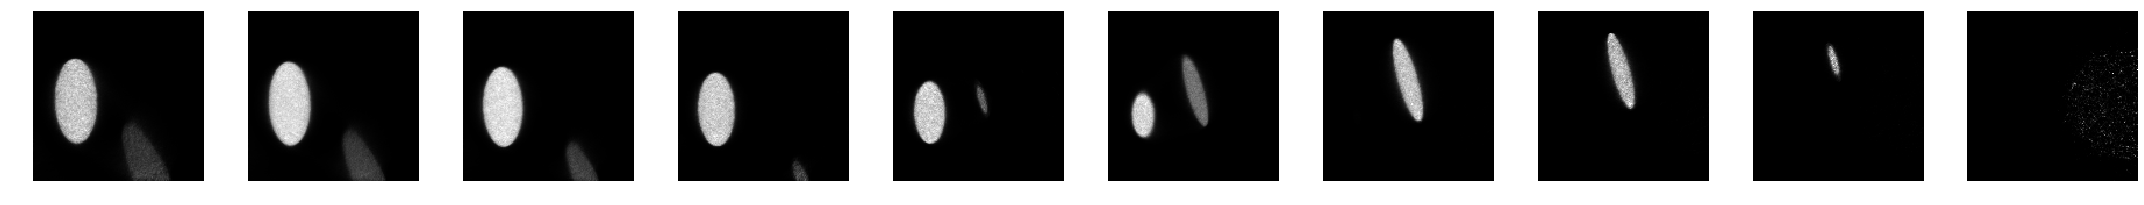

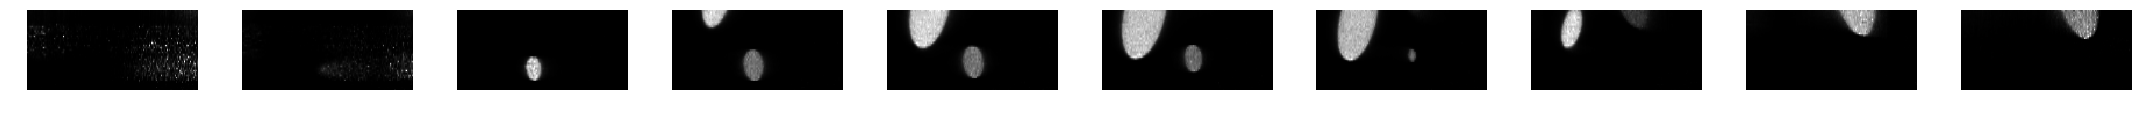

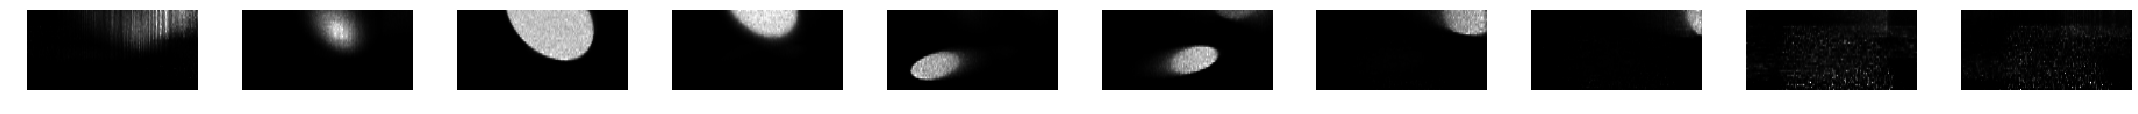

In [20]:
# 10 iterations MLEM reconstruction visualization

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_test_10[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_test_10[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_test_10[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

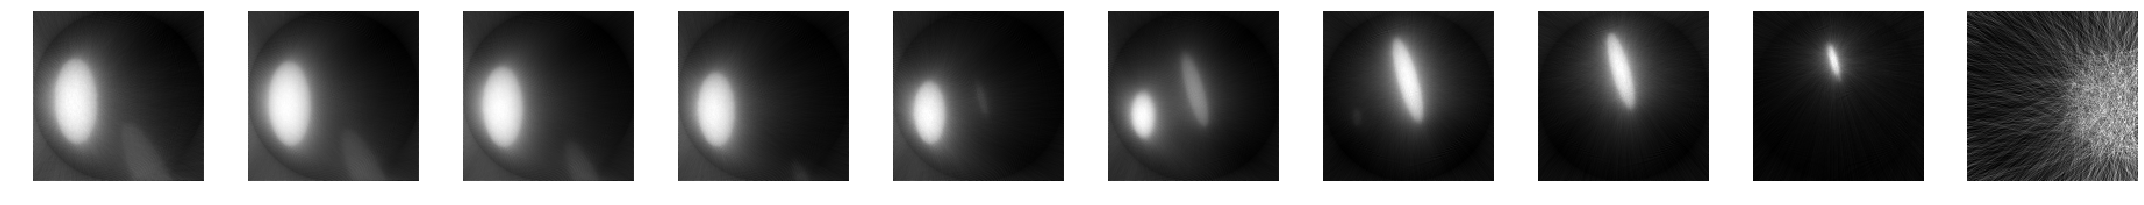

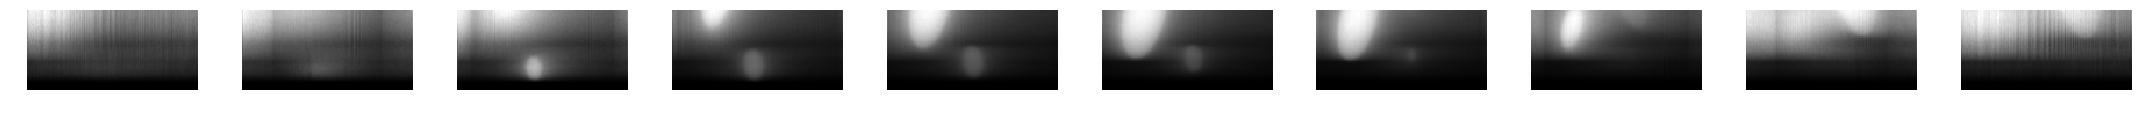

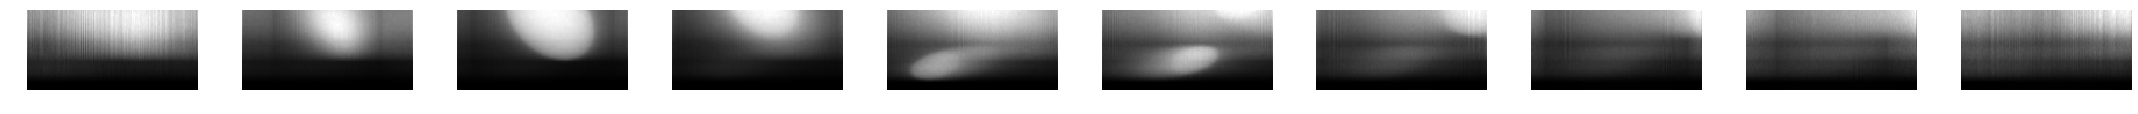

In [21]:
# 1 iteration MLEM: visualization

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_test_1[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_test_1[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-1,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_test_1[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

In [22]:
# Define the architecture of the network: 3D U-NET

def double_conv(in_channels, out_channels): # Double convolution + batch normalization + ReLU done in each layer
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, 3, padding=1),  # 2D convolution
        nn.BatchNorm3d(out_channels), # Batch normalization
        nn.ReLU(inplace=True), # Rectified Linear Unit
        nn.Conv3d(out_channels, out_channels, 3, padding=1), # 2D convolution
        nn.BatchNorm3d(out_channels), # Batch normalization
        nn.ReLU(inplace=True), # Rectified Linear Unit
    )   


class UNet3d(nn.Module): # U-Net 3D architecture

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64) # One input channel, 64 output channels 
        self.dconv_down2 = double_conv(64, 128) # 64 input channels, 128 output channels 
        self.dconv_down3 = double_conv(128, 256) # 128 input channels, 256 output channels 
        self.dconv_down4 = double_conv(256, 512) # 256 input channels, 512 output channels
        self.dconv_down5 = double_conv(512, 1024) # 512 input channels, 1024 output channels

        self.maxpool = nn.MaxPool3d(2,ceil_mode=True) # 2x pooling
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)   # 2x upsampling, with a bilinear interpolation and corner alignment     
        
        self.dconv_up4 = double_conv(512 + 1024, 512) # 512 + 1024 input channels, 512 output channels
        self.dconv_up3 = double_conv(256 + 512, 256) # 256 + 512 input channels, 256 output channels 
        self.dconv_up2 = double_conv(128 + 256, 128) # 128 + 256 input channels, 128 output channels
        self.dconv_up1 = double_conv(128 + 64, 64) # 128 + 64 input channels, 128 output channels
        
        self.conv_last = nn.Conv3d(64, 1, 1) # 64 input channels, one output channel and a kernel size of 1 (fully-connected layer)
        
        
    def forward(self, x):
        # Downsampling: Convolution + Pooling
        
        # Layer 1
        conv1 = self.dconv_down1(x) 
        x = self.maxpool(conv1)
        
        # Layer 2
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        # Layer 3
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        # Layer 4
        x = self.dconv_down4(x)
        x = self.maxpool(conv4)
    
    
        #x = self.dconv_down5(x)
        # Upsampling: Convolution + Upsampling with Bilinear Interpolation
        
        #x = self.upsample(x)    
        
        #if x.shape[2]*x.shape[3]==conv4.shape[2]*conv4.shape[3]:
           # x = torch.cat([x, conv4], dim=1)
        #else:
         #   x = torch.cat([F.interpolate(x,size=(conv4.shape[2],conv4.shape[3],conv4.shape[4])), conv4], dim=1)  
        
        
        
        
        #x = self.dconv_up4(x)
        #x = self.upsample(x)
        
        if x.shape[2]*x.shape[3]*x.shape[4]==conv3.shape[2]*conv3.shape[3]*conv3.shape[4]:
            x = torch.cat([x, conv3], dim=1)
        else:
            x = torch.cat([F.interpolate(x,size=(conv3.shape[2],conv3.shape[3],conv3.shape[4])), conv3], dim=1)
        
        
        
        x = self.dconv_up3(x)
        x = self.upsample(x)    
        # Layer 3
        if x.shape[2]*x.shape[3]*x.shape[4]==conv2.shape[2]*conv2.shape[3]*conv2.shape[4]:
            x = torch.cat([x, conv2], dim=1)
        else:
             x = torch.cat([F.interpolate(x,size=(conv2.shape[2],conv2.shape[3],conv2.shape[4])), conv2], dim=1)     
        
        
        x = self.dconv_up2(x)
        x = self.upsample(x) 
        # Layer 2
        if x.shape[2]*x.shape[3]*x.shape[4]==conv1.shape[2]*conv1.shape[3]*conv1.shape[4]:
            x = torch.cat([x, conv1], dim=1)
        else:
             x = torch.cat([F.interpolate(x,size=(conv1.shape[2],conv1.shape[3],conv1.shape[4])), conv1], dim=1)  
        
        # Layer 1
        x = self.dconv_up1(x)
        
        # Output layer
        
        out = self.conv_last(x)

        return out


In [23]:
def train(epoch): # Function to perform network training
    denoise_net.train() # Set model to training
    for batch_idx,images in enumerate(train_loader): # Go through all training images according to the different batches used
        #if use_cuda: # Move training images to GPU
            #images = images.cuda()
        projs = generate_data(images,fwd_op_mod,noise_level=1/3) # Add random Poisson noise to the train images
        noisy_recos = mlem_op_net_mod(projs) # Reconstruct the training images with the noise
        
        # Data normalization
        #noisy_recos=(noisy_recos/(0.9*torch.tensor(np.max(noisy_recos.flatten().numpy()))))
        
        
        # Data downsampling: SAVE CUDA MEMORY
        
        noisy_recos_down=torch.tensor(zoom(noisy_recos.numpy(),(1,1,0.5,0.5,1))) # Downsampled noisy reconstructions
        images_down=torch.tensor(zoom(images.numpy(),(1,1,0.5,0.5,1))) # Downsampled ground truths
        
        optimizer.zero_grad() # Clear the gradient results in the optimizer
        output = denoise_net(noisy_recos_down.cuda()) # Obtain the output of the first forward pass
        
        #img=torch.tensor(images, requires_grad=True)
        #img=(img.cpu()/(0.9*torch.tensor(np.max(img.flatten().cpu().detach().numpy()))))
        
        
        
        
        loss = loss_train(output, images_down.cuda().float()) # Compute the loss function with respect to some Ground Truth or target
        loss.backward() # Start back-propagation
        optimizer.step() # Define some optimizer step
        if batch_idx % log_interval == 0: # Print the progress of the training according to the epoch number, the batch number and the loss function
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss))
        
        if batch_idx==len(train_loader)-1:
            return loss.data

def test(): # Obtain test results with the given trained network
    denoise_net.eval() # Set model to evaluation
    
    # Data downsampling: save memory
    reco=mlem_op_net_mod(test_data) # MLEM reconstruction with one iteration of the test ground truths
    reco_down=torch.tensor(zoom(reco.numpy(),(1,1,0.5,0.5,0.5))) # Downsampled noisy reconstructions
    test_down=torch.tensor(zoom(test_images.numpy(),(1,1,0.5,0.5,0.5))).cuda() # Downsampled test ground truth
    #reco=(reco.cpu()/(0.9*torch.tensor(np.max(reco.cpu().flatten().numpy()))))
    
    #img=torch.tensor(test_images, requires_grad=True)
    #img=img/(0.9*torch.tensor(np.max(img.flatten().cpu().detach().numpy())))
    
    loss = (loss_train(denoise_net(reco_down.cuda()), test_down.float()))
    print('\nTest set: Average loss: {:.6f}'.format(loss.data)) # Evaluate accuracy of test set with the loss function, as the targets of the test set are also known
    return loss.data

In [57]:
# Load model checkpoint, especially to resume training

denoise_net = UNet3d() # Model to train
optimizer = optim.Adam(denoise_net.parameters(), lr=1.5e-03) # Optimizer to load

checkpoint = torch.load('andres_final_3d_checkpoint_all.tar') # Load checkpoint to resume training
denoise_net.load_state_dict(checkpoint['model_state_dict']) # Load model state
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state
epochs = checkpoint['epoch'] # Load epoch
loss_train = checkpoint['loss'] # Load loss function

denoise_net.train() # Set network to training

UNet3d(
  (dconv_down1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
  (dconv_down2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
  (dconv_down3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(25

In [58]:
# Move optimizer parameters also to CUDA. Otherwise, the model loading does not work and provides error

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

In [60]:
use_cuda = True # Set model to work in GPU
log_interval=100
if use_cuda: # Implement these operators with CUDA
    denoise_net = denoise_net.cuda()

# Train with loaded model
train_error=[] # Compute training errors
test_error=[] # Compute validation errors

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_error.append(train(epoch)) # Train network and compute training errors
    #clear_output()
    test_error.append(test()) # Validate network and compute validation errors

Train Epoch: 1 [0/2000 (0%)]	Batch Loss: 0.010993
Train Epoch: 1 [100/2000 (5%)]	Batch Loss: 0.007371
Train Epoch: 1 [200/2000 (10%)]	Batch Loss: 0.016396
Train Epoch: 1 [300/2000 (15%)]	Batch Loss: 0.040518
Train Epoch: 1 [400/2000 (20%)]	Batch Loss: 0.083296
Train Epoch: 1 [500/2000 (25%)]	Batch Loss: 0.002651
Train Epoch: 1 [600/2000 (30%)]	Batch Loss: 0.000361
Train Epoch: 1 [700/2000 (35%)]	Batch Loss: 0.003567
Train Epoch: 1 [800/2000 (40%)]	Batch Loss: 0.012104
Train Epoch: 1 [900/2000 (45%)]	Batch Loss: 0.000254
Train Epoch: 1 [1000/2000 (50%)]	Batch Loss: 0.010492
Train Epoch: 1 [1100/2000 (55%)]	Batch Loss: 0.043226
Train Epoch: 1 [1300/2000 (65%)]	Batch Loss: 0.016655
Train Epoch: 1 [1500/2000 (75%)]	Batch Loss: 0.034083
Train Epoch: 1 [1600/2000 (80%)]	Batch Loss: 0.008349
Train Epoch: 1 [1700/2000 (85%)]	Batch Loss: 0.015114
Train Epoch: 1 [1900/2000 (95%)]	Batch Loss: 0.014676

Test set: Average loss: 0.005352


In [61]:
# Save the whole model for further training, including optimizer steps (to resume training)
torch.save({
            'epoch': epochs,
            'model_state_dict': denoise_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_train,
            }, 'andres_final_3d_checkpoint_all.tar' )


In [62]:
# Reconstruct testing data with 1 MLEM iteration
reco=mlem_op_net_mod(test_data)


# Data downsampling to save CUDA memory
reco_down=torch.tensor(zoom(reco.numpy(),(1,1,0.5,0.5,0.5))) # Downsampled noisy reconstructions
#test_down=torch.tensor(zoom(test_images.numpy(),(0.5,0.5,1))).cuda() # Downsampled test ground truth

test_res_denoise = denoise_net(reco_down.cuda()).detach().cpu().numpy() # Obtained denoised results with the given network

# Data upsampling
test_res_denoise=zoom(test_res_denoise,(1,1,2,2,2)) # Upsampled result to original resolution

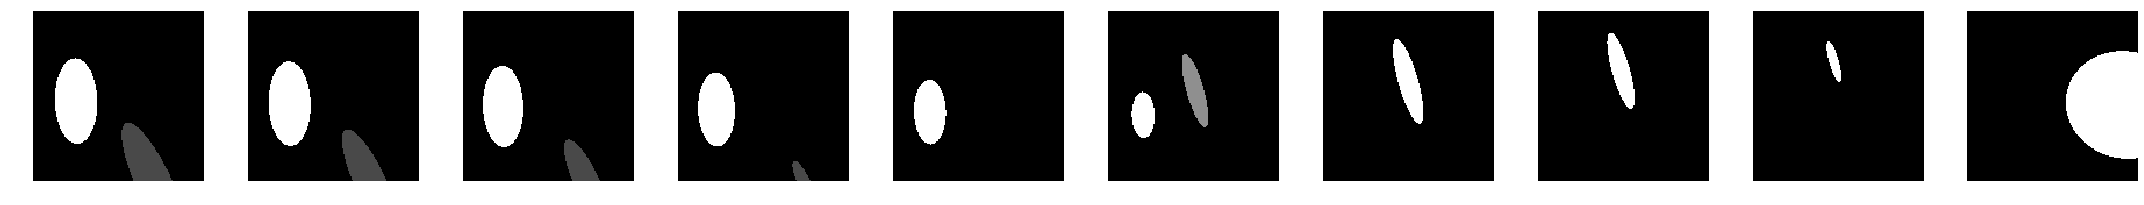

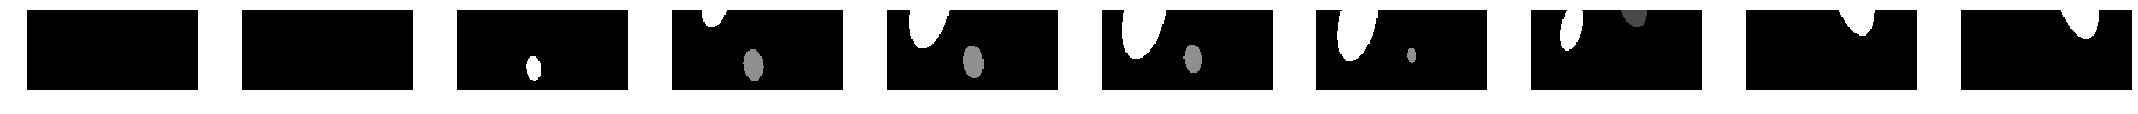

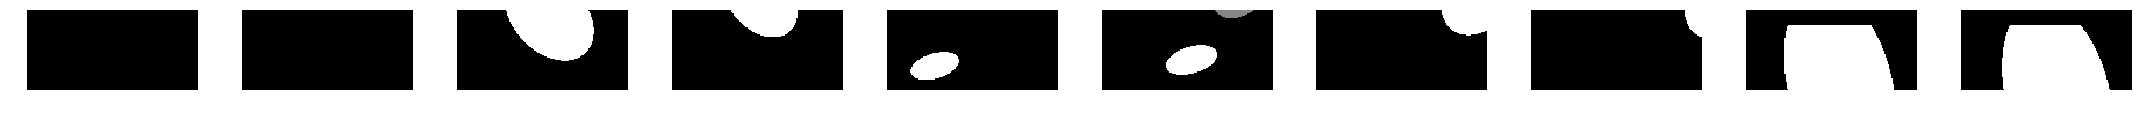

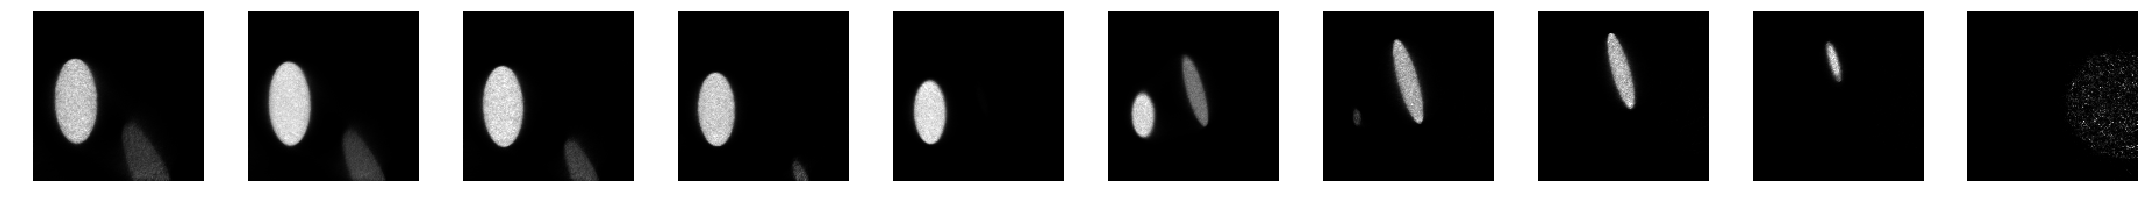

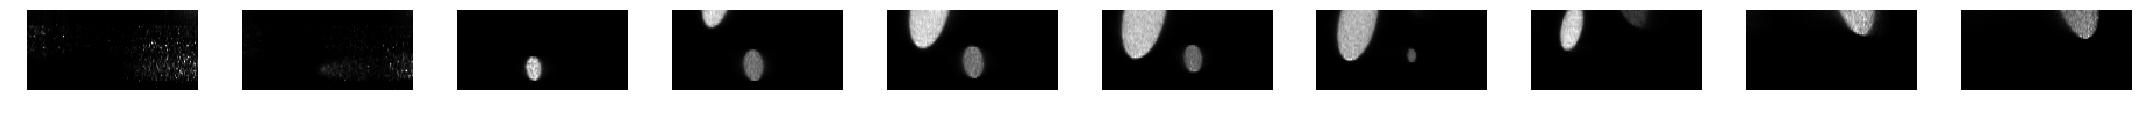

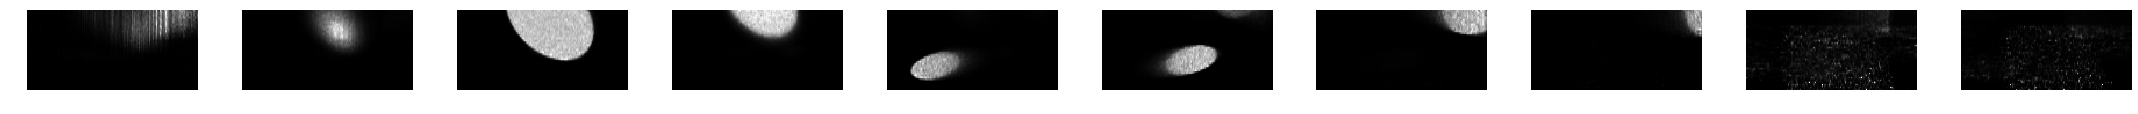

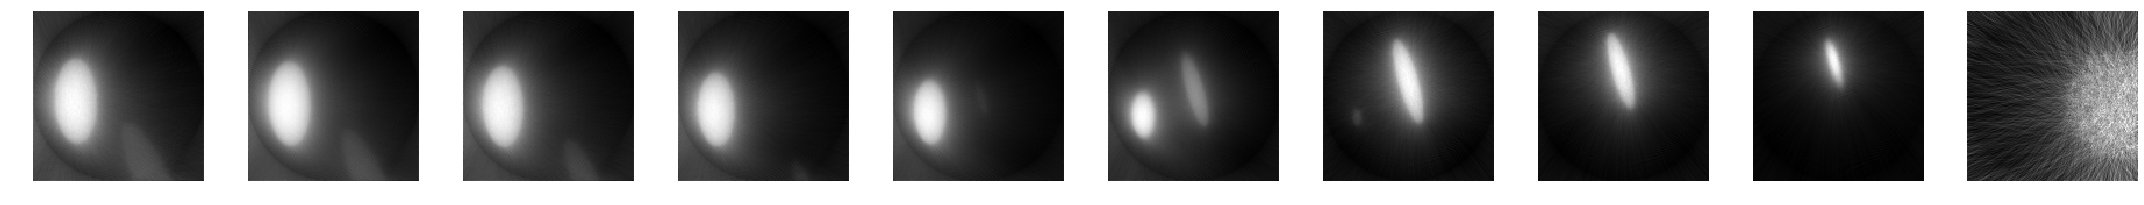

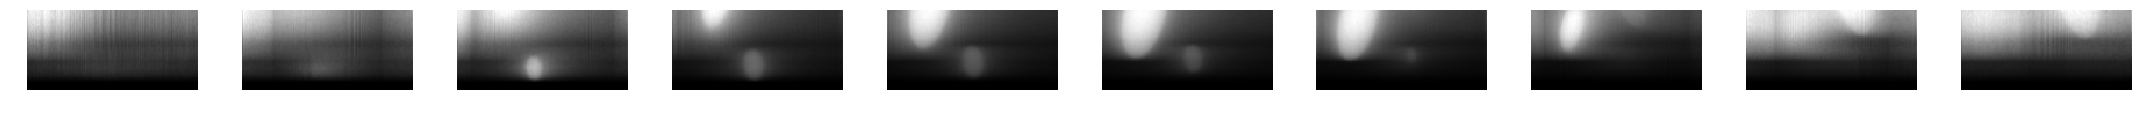

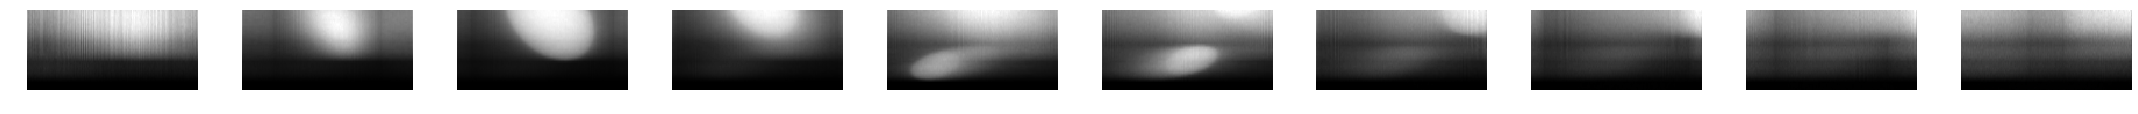

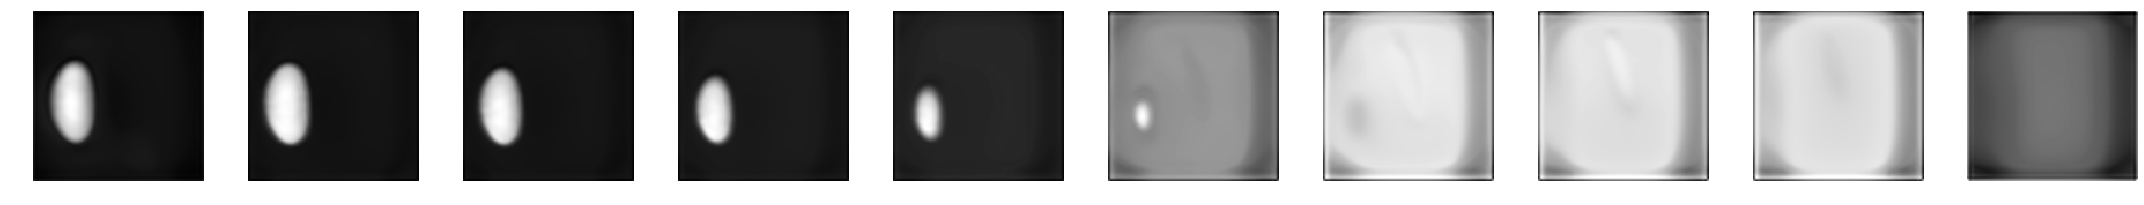

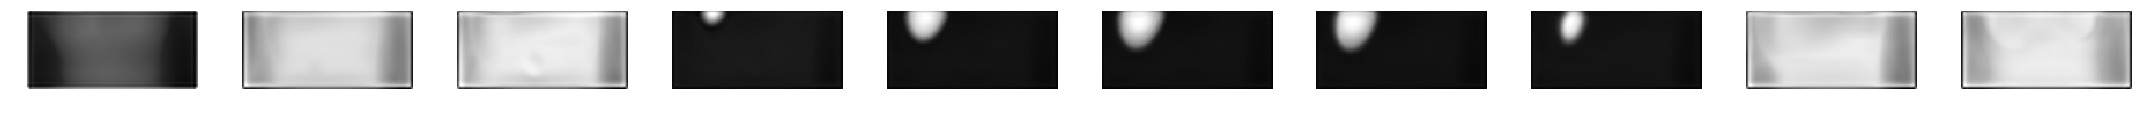

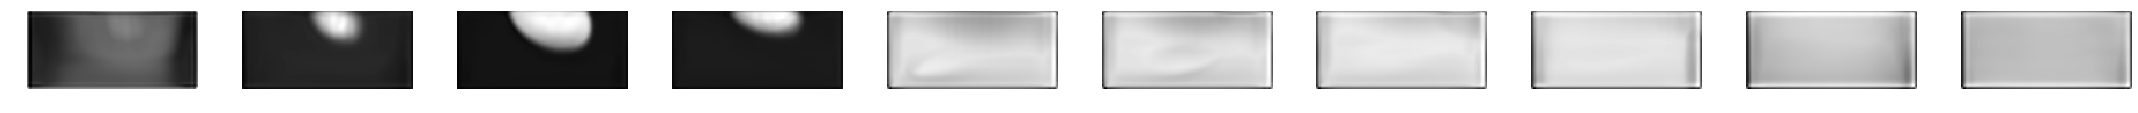

In [63]:
# RESULT VISUALIZATION

num=0 # Image index


# GROUND-TRUTH

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=test_images[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=test_images[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=test_images[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# MLEM RECONSTRUCTION WITH 10 ITERATIONS

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_test_10[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_test_10[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_test_10[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()



# MLEM RECONSTRUCTION WITH 1 ITERATION

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_test_1[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_test_1[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_test_1[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# DENOISED IMAGES WITH ELLIPSOIDS NETWORK

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=test_res_denoise[num,0,ind,:,:]
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=test_res_denoise[num,0,:,ind,:]
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=test_res_denoise[num,0,:,:,ind]
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


In [32]:
use_cuda = True
log_interval=100
if use_cuda: # Implement these operators with CUDA
    denoise_net = denoise_net.cuda()

In [36]:
# Implement further training without losing the visualization of previous results

# Train with loaded model
train_error=[]
test_error=[]

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_error.append(train(epoch))
    #clear_output()
    test_error.append(test())

Train Epoch: 1 [0/1000 (0%)]	Batch Loss: 0.012766
Train Epoch: 1 [100/1000 (10%)]	Batch Loss: 0.003782
Train Epoch: 1 [200/1000 (20%)]	Batch Loss: 0.106173
Train Epoch: 1 [300/1000 (30%)]	Batch Loss: 0.003203
Train Epoch: 1 [400/1000 (40%)]	Batch Loss: 0.001566
Train Epoch: 1 [500/1000 (50%)]	Batch Loss: 0.005739
Train Epoch: 1 [700/1000 (70%)]	Batch Loss: 0.057402
Train Epoch: 1 [800/1000 (80%)]	Batch Loss: 0.013457


NameError: name 'loss_test' is not defined

In [37]:
# Reconstruct data with 1 iteration MLEM
reco=mlem_op_net_mod(test_data)


# Data downsampling
reco_down=torch.tensor(zoom(reco.numpy(),(1,1,0.5,0.5,0.5))) # Downsampled noisy reconstructions
#test_down=torch.tensor(zoom(test_images.numpy(),(0.5,0.5,1))).cuda() # Downsampled test ground truth

test_res_denoise = denoise_net(reco_down.cuda()).detach().cpu().numpy() # Obtained denoised results with the given network

# Data upsampling
test_res_denoise=zoom(test_res_denoise,(1,1,2,2,2)) # Upsampled result to original resolution

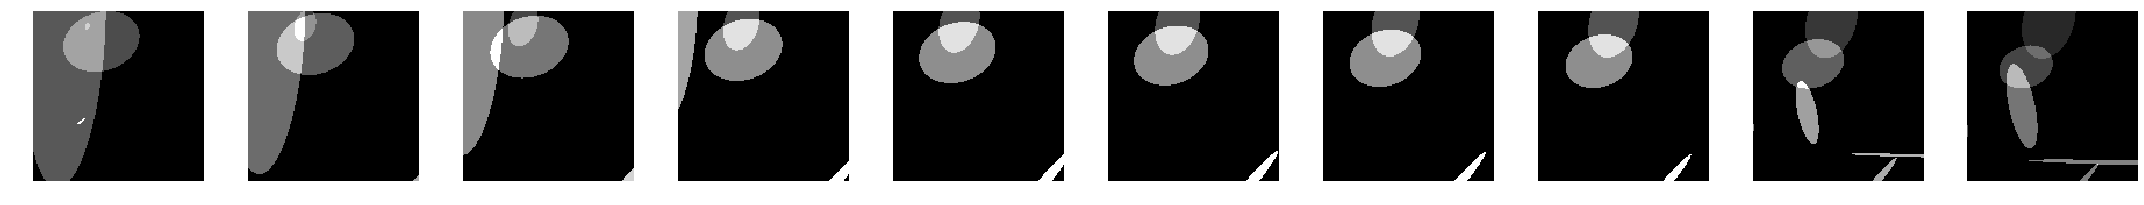

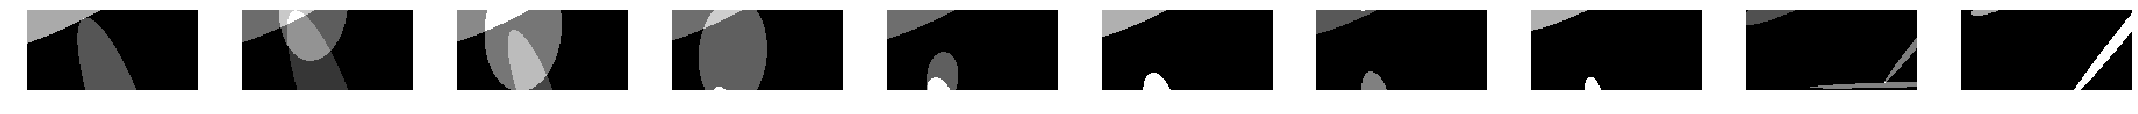

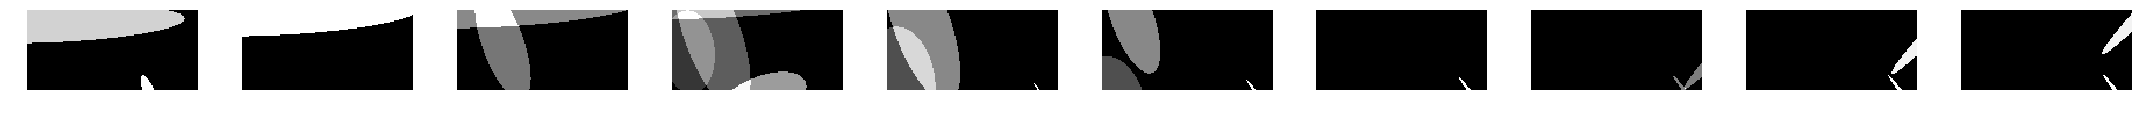

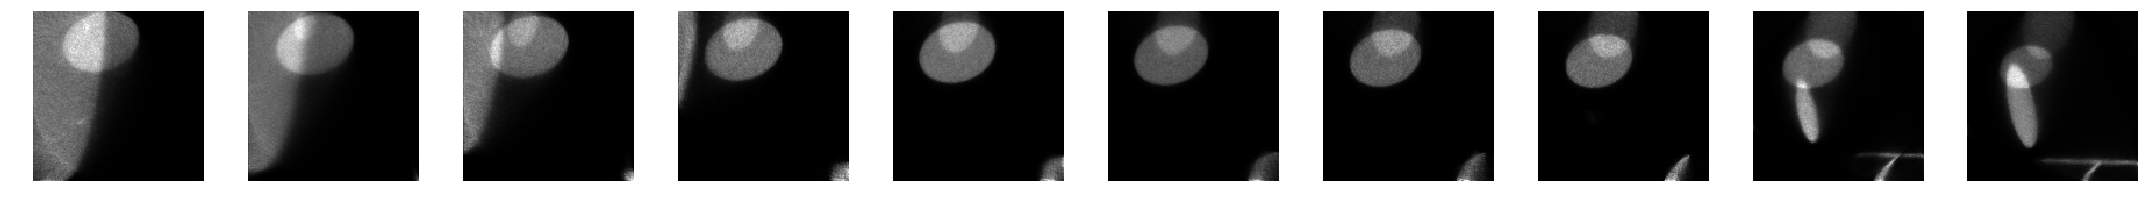

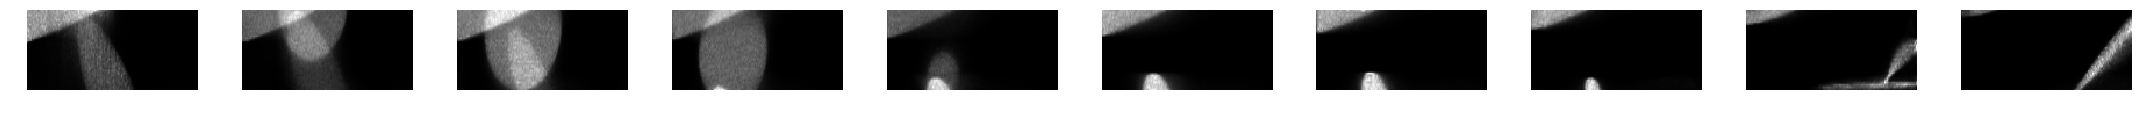

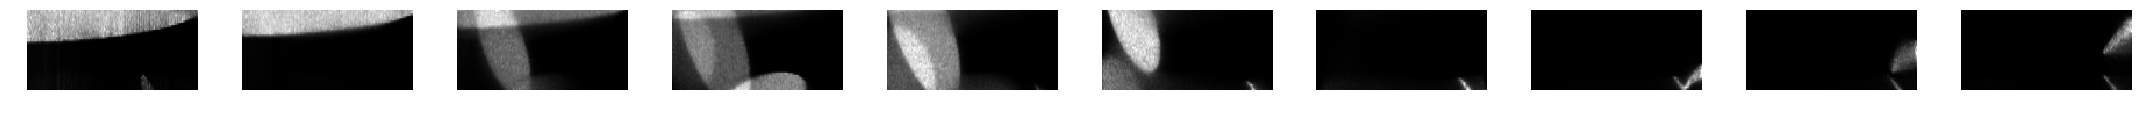

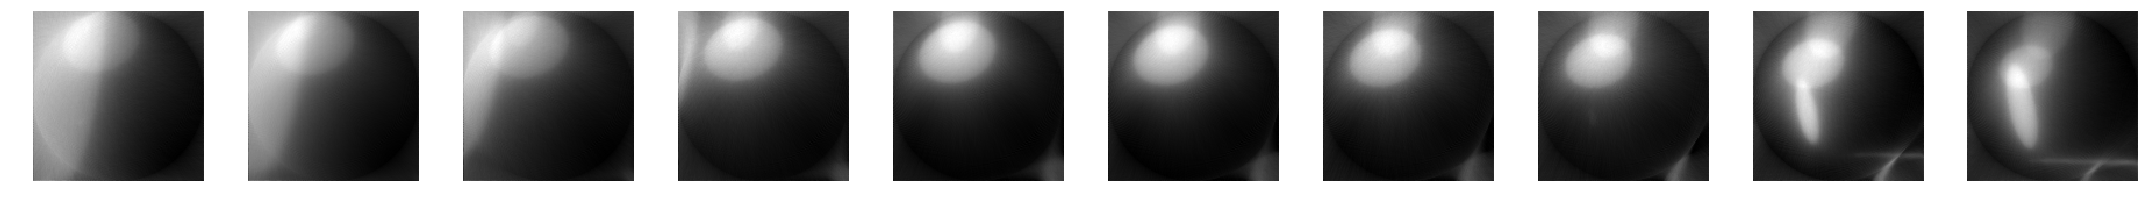

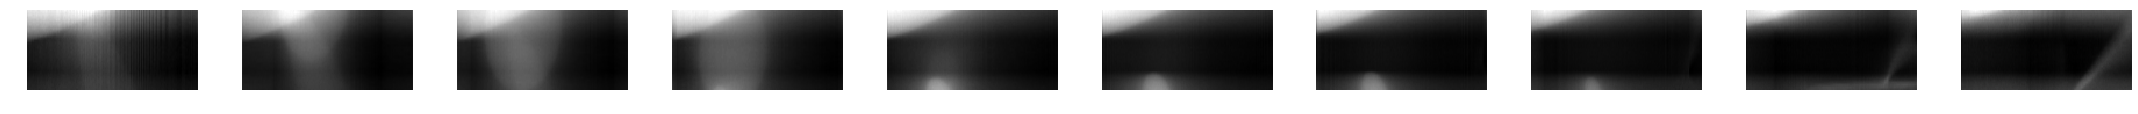

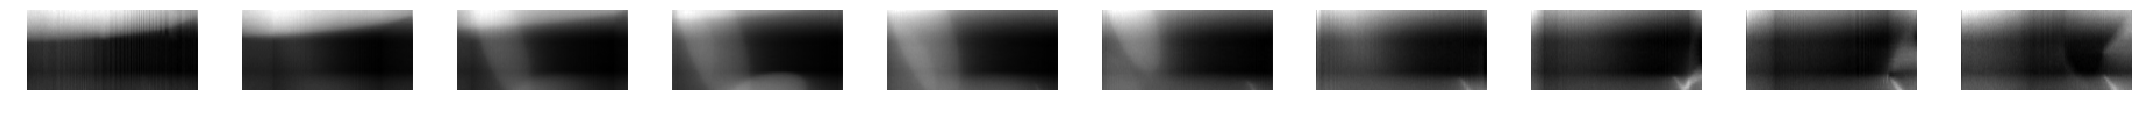

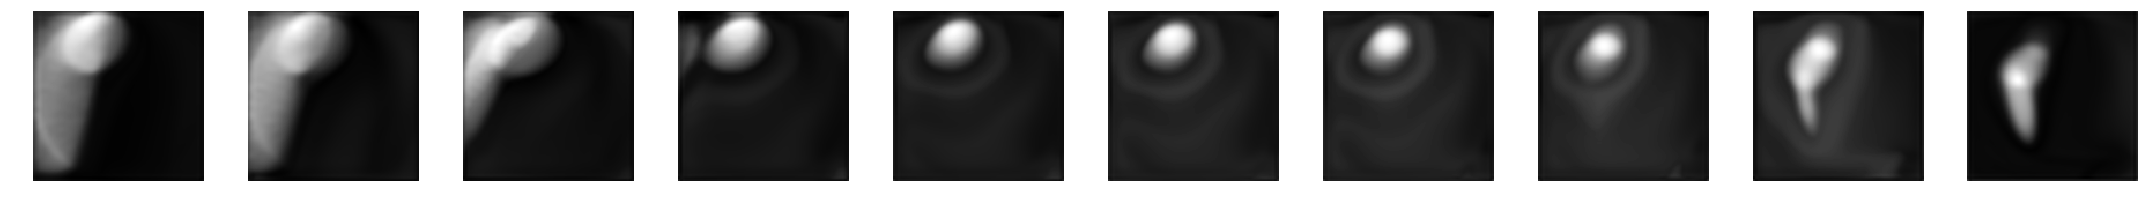

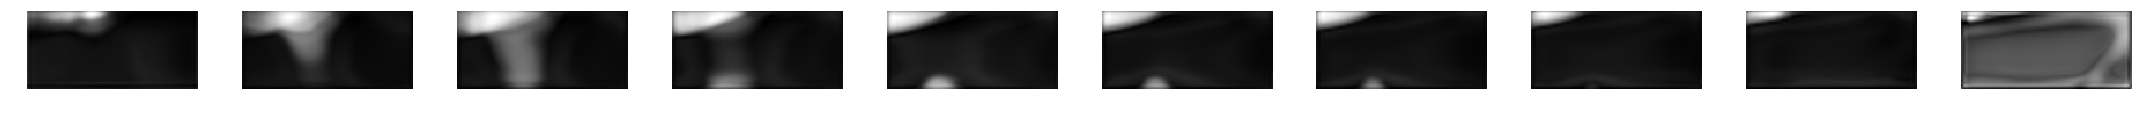

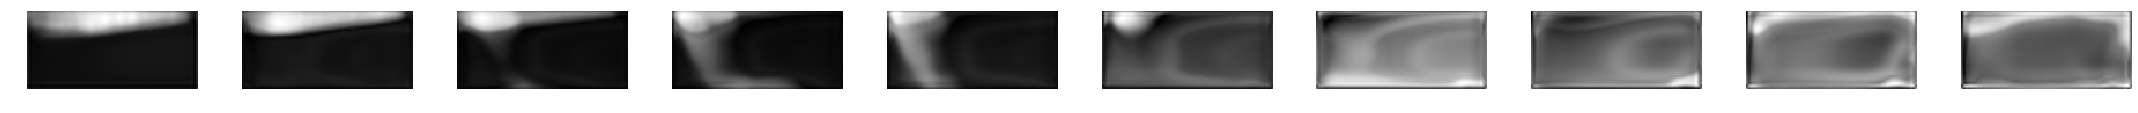

In [38]:
# RESULT VISUALIZATION

num=0 # Image index


# GROUND-TRUTH

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=test_images[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=test_images[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 

# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=test_images[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# MLEM RECONSTRUCTION WITH 10 ITERATIONS

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_test_10[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_test_10[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_test_10[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()



# MLEM RECONSTRUCTION WITH 1 ITERATION

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_test_1[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_test_1[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_test_1[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# DENOISED IMAGES WITH ELLIPSOIDS NETWORK

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=test_res_denoise[num,0,ind,:,:]
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=test_res_denoise[num,0,:,ind,:]
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=test_res_denoise[num,0,:,:,ind]
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


In [52]:
# NORMALIZATION OF IMAGES (have the same dynamic range, from 0 to 1)
test_images_norm=np.copy(test_images.cpu().numpy().squeeze())
mlem_10_norm=np.copy(mlem_test_10.cpu().numpy().squeeze())
denoised_norm=np.copy(test_res_denoise.squeeze())
#denoised_norm_mnist=np.copy(test_res_denoise_mnist.squeeze())

index=[]
for i in range(test_images.shape[0]):
    if np.amax(test_images_norm[i,:,:].flatten())!=0:
        index.append(i)

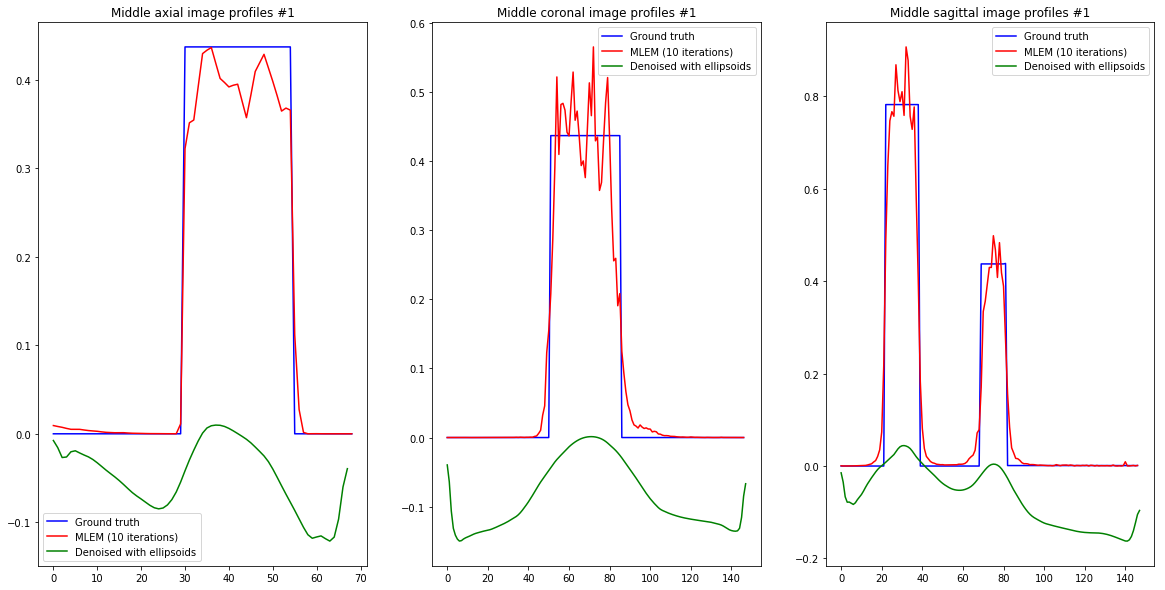

In [53]:
# Middle profile observation for axial, coronal and sagittal views

# Axial slices
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(range(test_images_norm.shape[0]),test_images_norm[:,int(test_images_norm.shape[1]/2),int(test_images_norm.shape[2]/2)],'b',label='Ground truth')
plt.title('Middle axial image profiles #'+str(num+1))
plt.plot(range(test_images_norm.shape[0]),mlem_10_norm[:,int(test_images_norm.shape[1]/2),int(test_images_norm.shape[2]/2)],'r',label='MLEM (10 iterations)')
plt.plot(range(test_images_norm.shape[0]-1),denoised_norm[:,int(test_images_norm.shape[1]/2),int(test_images_norm.shape[2]/2)].squeeze(),'g',label='Denoised with ellipsoids') 
#plt.plot(range(test_images_norm.shape[0]-1),denoised_norm_mnist[:,int(test_images_norm.shape[1]/2),int(test_images_norm.shape[2]/2)].squeeze(),'k',label='Denoised with MNIST')
plt.legend()

# Coronal slices
plt.subplot(1,3,2)
plt.plot(range(test_images_norm.shape[1]),test_images_norm[int(test_images_norm.shape[0]/2),:,int(test_images_norm.shape[2]/2)],'b',label='Ground truth')
plt.title('Middle coronal image profiles #'+str(num+1))
plt.plot(range(test_images_norm.shape[1]),mlem_10_norm[int(test_images_norm.shape[0]/2),:,int(test_images_norm.shape[2]/2)],'r',label='MLEM (10 iterations)')
plt.plot(range(test_images_norm.shape[1]+1),denoised_norm[int(test_images_norm.shape[0]/2),:,int(test_images_norm.shape[2]/2)].squeeze(),'g',label='Denoised with ellipsoids') 
#plt.plot(range(test_images_norm.shape[1]+1),denoised_norm_mnist[int(test_images_norm.shape[0]/2),:,int(test_images_norm.shape[2]/2)].squeeze(),'k',label='Denoised with MNIST')
plt.legend()


# Sagittal slices
plt.subplot(1,3,3)
plt.plot(range(test_images_norm.shape[2]),test_images_norm[int(test_images_norm.shape[0]/2),int(test_images_norm.shape[1]/2),:],'b',label='Ground truth')
plt.title('Middle sagittal image profiles #'+str(num+1))
plt.plot(range(test_images_norm.shape[2]),mlem_10_norm[int(test_images_norm.shape[0]/2),int(test_images_norm.shape[1]/2),:],'r',label='MLEM (10 iterations)')
plt.plot(range(test_images_norm.shape[2]+1),denoised_norm[int(test_images_norm.shape[0]/2),int(test_images_norm.shape[1]/2),:].squeeze(),'g',label='Denoised with ellipsoids') 
#plt.plot(range(test_images_norm.shape[2]+1),denoised_norm_mnist[int(test_images_norm.shape[0]/2),int(test_images_norm.shape[1]/2),:].squeeze(),'k',label='Denoised with MNIST')
plt.legend()

In [54]:
def peak_SNR(img,ground_truth):
    
    # Compute the peak SNR between an image and its ground truth
    # Normalization: make both images have a maximum value of 1
    img=torch.tensor(img/np.amax(img.flatten()))
    ground_truth=torch.tensor(ground_truth/np.amax(ground_truth.flatten()))
    
    mse=nn.MSELoss() # Define the Mean Square Error
    return -10*np.log10(mse(img,ground_truth.float())) # Expression for PSNR

In [55]:
# Evaluate results in terms of SSIM and PSNR

# Fit dimensions for resampled data

test_images_norm_red=test_images_norm[0:denoised_norm.shape[0],:,:]
denoised_norm_red=denoised_norm[:,0:test_images_norm.shape[1],0:test_images_norm.shape[2]]
#denoised_norm_mnist_red=denoised_norm_mnist_norm[:,0:test_images_norm.shape[1],0:test_images_norm.shape[2]]

# Compute Structural Similarity Index, SSIM
mlem_ssim=fom.ssim(mlem_10_norm,test_images_norm) # SSIM for the MLEM reconstructed images
#mnist_ssim=fom.ssim(denoised_norm_mnist_red,test_images_norm_red) # SSIM for the denoised images with the MNIST network
ellipses_ssim=fom.ssim(denoised_norm_red,test_images_norm_red) # SSIM for the denoised images with the ellipsoid network

# Compute Peak Signal-to-Noise Ratio, PSNR
mlem_psnr=peak_SNR(mlem_10_norm,test_images_norm) # PSNR for the MLEM reconstructed images
#mnist_psnr=peak_SNR(denoised_norm_mnist_red,test_images_norm_red) # PSNR for the denoised images with the MNIST network
ellipses_psnr=peak_SNR(denoised_norm_red,test_images_norm_red) # PSNR for the denoised images with the ellipsoid network

print('\nSSIM for MLEM reconstructed images with 10 iterations: {}'.format(mlem_ssim))
#print('\nSSIM for denoised images with MNIST network: {}'.format(mnist_ssim))
print('\nSSIM for denoised images with ellipsoids network: {}\n'.format(ellipses_ssim))

print('\nPSNR for MLEM reconstructed images with 10 iterations: {}'.format(mlem_psnr))
#print('\nPSNR for denoised images with MNIST network: {}'.format(mnist_psnr))
print('\nPSNR for denoised images with ellipsoids network: {}\n'.format(ellipses_psnr))


SSIM for MLEM reconstructed images with 10 iterations: 0.9007923476156439

SSIM for denoised images with ellipsoids network: 0.04120039177660863


PSNR for MLEM reconstructed images with 10 iterations: 21.49446678161621

PSNR for denoised images with ellipsoids network: 13.493185043334961



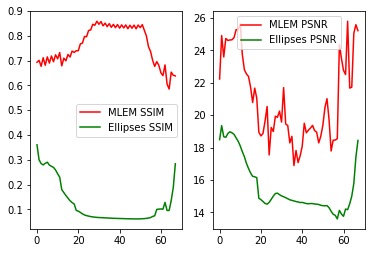

In [45]:
# Evaluate the SSIM and the PSNR image by image: AXIAL SLICES

mlem_ssim_list=[] # SSIM values for 10 iterations MLEM in axial cuts
ellipses_ssim_list=[] # SSIM values for ellipsoids denoising in axial cuts
#mnist_ssim_list=[] # SSIM values for MNIST network denoising in axial cuts

mlem_psnr_list=[] # PSNR values for 10 iterations MLEM in axial cuts
ellipses_psnr_list=[] # PSNR values for ellipsoids denoising in axial cuts
#mnist_psnr_list=[] # PSNR values for MNIST network denoising in axial cuts

for i in range(denoised_norm.shape[0]): # Compute for all axial slices
    mlem_ssim_list.append(fom.ssim(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_ssim_list.append(fom.ssim(denoised_norm_red[i,:,:],test_images_norm_red[i,:,:]))
    #mnist_ssim_list.append(fom.ssim(denoised_norm_mnist_red[i,:,:],test_images_norm_red[i,:,:]))
    mlem_psnr_list.append(peak_SNR(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_psnr_list.append(peak_SNR(denoised_norm_red[i,:,:],test_images_norm_red[i,:,:]))
    #mnist_psnr_list.append(peak_SNR(denoised_norm_mnist_red[i,:,:],test_images_norm_red[i,:,:]))
    
# Plot everything
plt.figure()
plt.subplot(1,2,1)
plt.plot(range(denoised_norm.shape[0]),mlem_ssim_list,'r',label='MLEM SSIM')
plt.plot(range(denoised_norm.shape[0]),ellipses_ssim_list,'g',label='Ellipses SSIM')
#plt.plot(range(denoised_norm.shape[0]),mnist_ssim_list,'k',label='MNIST SSIM')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(denoised_norm.shape[0]),mlem_psnr_list,'r',label='MLEM PSNR')
plt.plot(range(denoised_norm.shape[0]),ellipses_psnr_list,'g',label='Ellipses PSNR')
#plt.plot(range(denoised_norm.shape[0]),mnist_psnr_list,'k',label='MNIST PSNR')
plt.legend()

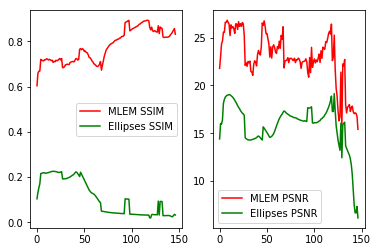

In [46]:
# Evaluate the SSIM and the PSNR image by image: CORONAL SLICES

mlem_ssim_list=[] # SSIM values for 10 iterations MLEM in coronal cuts
ellipses_ssim_list=[] # SSIM values for ellipsoids denoising in coronal cuts
#mnist_ssim_list=[] # SSIM values for MNIST network denoising in coronal cuts

mlem_psnr_list=[] # PSNR values for 10 iterations MLEM in coronal cuts
ellipses_psnr_list=[] # PSNR values for ellipsoids denoising in coronal cuts
#mnist_psnr_list=[] # PSNR values for MNIST network denoising in coronal cuts

for i in range(test_images_norm.shape[1]):
    mlem_ssim_list.append(fom.ssim(mlem_10_norm[:,i,:],test_images_norm[:,i,:]))
    ellipses_ssim_list.append(fom.ssim(denoised_norm_red[:,i,:],test_images_norm_red[:,i,:]))
    #mnist_ssim_list.append(fom.ssim(denoised_norm_mnist_red[:,i,:],test_images_norm_red[:,i,:]))
    mlem_psnr_list.append(peak_SNR(mlem_10_norm[:,i,:],test_images_norm[:,i,:]))
    ellipses_psnr_list.append(peak_SNR(denoised_norm_red[:,i,:],test_images_norm_red[:,i,:]))
    #mnist_psnr_list.append(peak_SNR(denoised_norm_mnist_red[:,i,:],test_images_norm_red[:,i,:]))
    

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(test_images_norm.shape[1]),mlem_ssim_list,'r',label='MLEM SSIM')
plt.plot(range(test_images_norm.shape[1]),ellipses_ssim_list,'g',label='Ellipses SSIM')
#plt.plot(range(test_images_norm.shape[1]),mnist_ssim_list,'k',label='MNIST SSIM')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(test_images_norm.shape[1]),mlem_psnr_list,'r',label='MLEM PSNR')
plt.plot(range(test_images_norm.shape[1]),ellipses_psnr_list,'g',label='Ellipses PSNR')
#plt.plot(range(test_images_norm.shape[1]),mnist_psnr_list,'k',label='MNIST PSNR')
plt.legend()

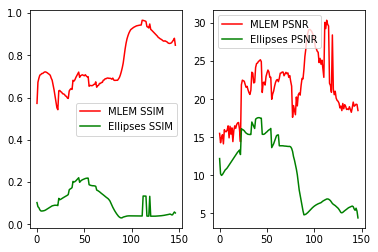

In [47]:
# Evaluate the SSIM and the PSNR image by image: SAGITTAL SLICES

mlem_ssim_list=[] # SSIM values for 10 iterations MLEM in sagittal cuts
ellipses_ssim_list=[] # SSIM values for ellipsoids denoising in sagittal cuts
#mnist_ssim_list=[] # SSIM values for MNIST network denoising in sagittal cuts

mlem_psnr_list=[] # PSNR values for 10 iterations MLEM in sagittal cuts
ellipses_psnr_list=[] # PSNR values for ellipsoids denoising in sagittal cuts
#mnist_psnr_list=[] # PSNR values for MNIST network denoising in sagittal cuts

for i in range(test_images_norm.shape[2]):
    mlem_ssim_list.append(fom.ssim(mlem_10_norm[:,:,i],test_images_norm[:,:,i]))
    ellipses_ssim_list.append(fom.ssim(denoised_norm_red[:,:,i],test_images_norm_red[:,:,i]))
    #mnist_ssim_list.append(fom.ssim(denoised_norm_mnist_red[:,:,i],test_images_norm_red[:,:,i]))
    mlem_psnr_list.append(peak_SNR(mlem_10_norm[:,:,i],test_images_norm[:,:,i]))
    ellipses_psnr_list.append(peak_SNR(denoised_norm_red[:,:,i],test_images_norm_red[:,:,i]))
    #mnist_psnr_list.append(peak_SNR(denoised_norm_mnist_red[:,:,i],test_images_norm_red[:,:,i]))
    

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(test_images_norm.shape[2]),mlem_ssim_list,'r',label='MLEM SSIM')
plt.plot(range(test_images_norm.shape[2]),ellipses_ssim_list,'g',label='Ellipses SSIM')
#plt.plot(range(test_images_norm.shape[2]),mnist_ssim_list,'k',label='MNIST SSIM')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(test_images_norm.shape[2]),mlem_psnr_list,'r',label='MLEM PSNR')
plt.plot(range(test_images_norm.shape[2]),ellipses_psnr_list,'g',label='Ellipses PSNR')
#plt.plot(range(test_images_norm.shape[2]),mnist_psnr_list,'k',label='MNIST PSNR')
plt.legend()

In [26]:
# Test denoising network with Shepp-Logan phantom
shepp_logan=np.zeros((1,1,pet_projector.domain.shape[0],pet_projector.domain.shape[1],pet_projector.domain.shape[2]))
shepp_logan[0,0,:,:,:]=odl.phantom.transmission.shepp_logan(pet_projector.domain, modified=True)

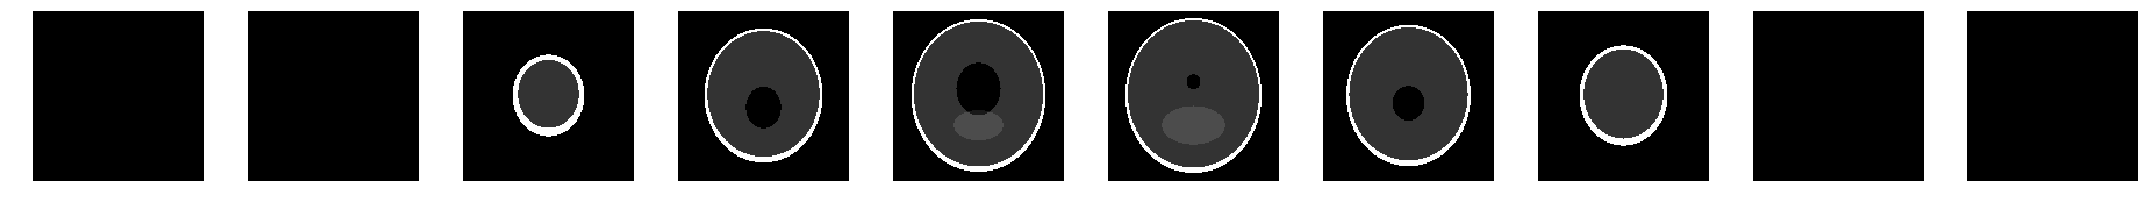

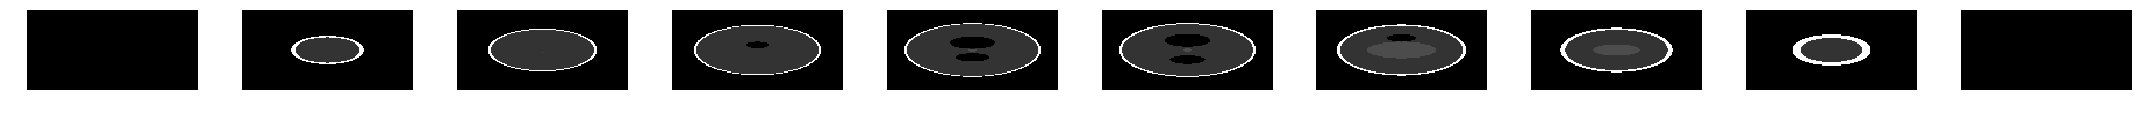

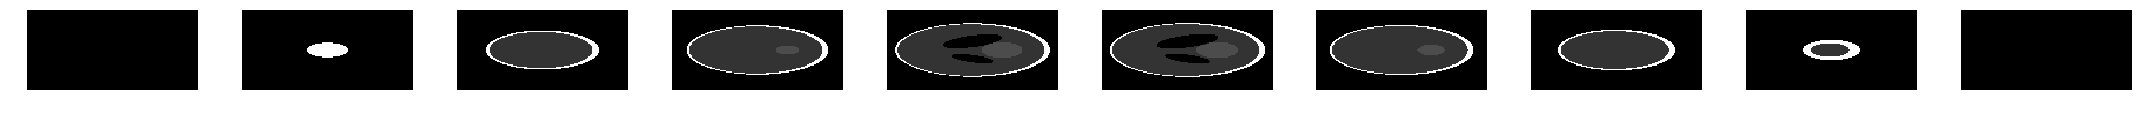

In [27]:
# Fly through images for Shepp-Logan

# Axial cuts
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=shepp_logan[num,0,ind,:,:]
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal cuts
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=shepp_logan[num,0,:,ind,:]
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal cuts
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=shepp_logan[num,0,:,:,ind]
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

In [29]:
# Sinogram for Shepp-Logan and adding noise
noise=1/3 # Noise level to introduce in the reconstruction
shepp_logan_data = generate_data(torch.tensor(shepp_logan),fwd_op_mod,noise_level=noise) # Provide noisy test images with Poisson distributed noise
# Obtain 10 iterations and 1 iteration MLEM for Shepp-Logan
mlem_10_shepp_logan=mlem_op_comp_mod(shepp_logan_data) # MLEM reconstruction of the test data with 10 iterations for further comparison
mlem_1_shepp_logan=mlem_op_net_mod(shepp_logan_data) # MLEM reconstruction of the test data with 1 iteration for further comparison

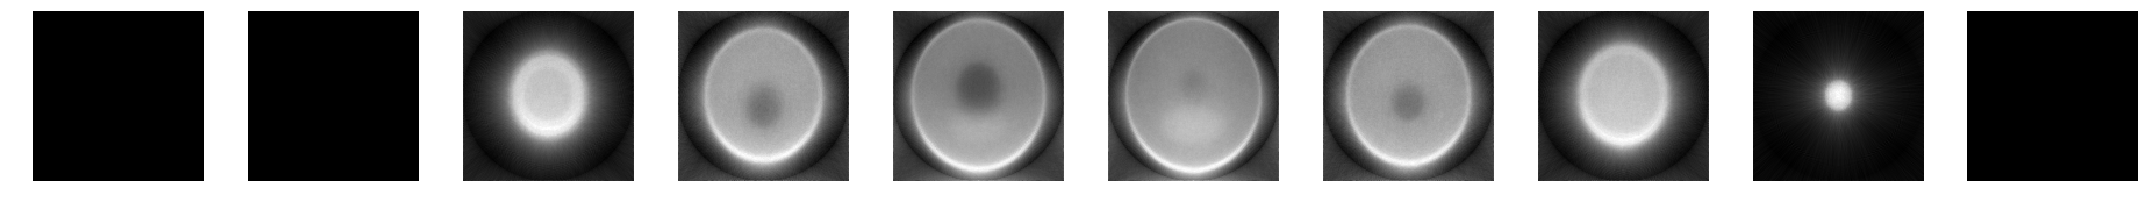

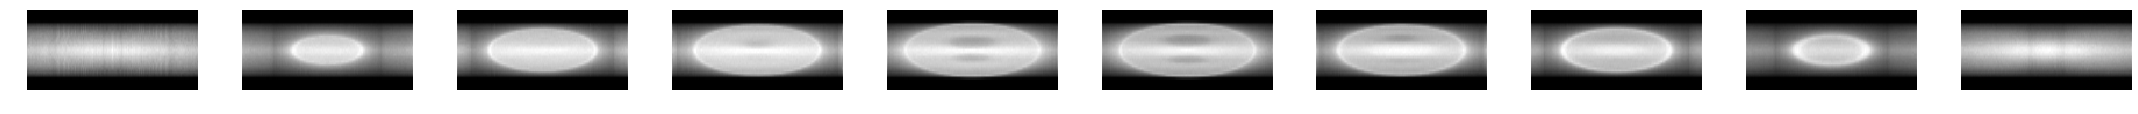

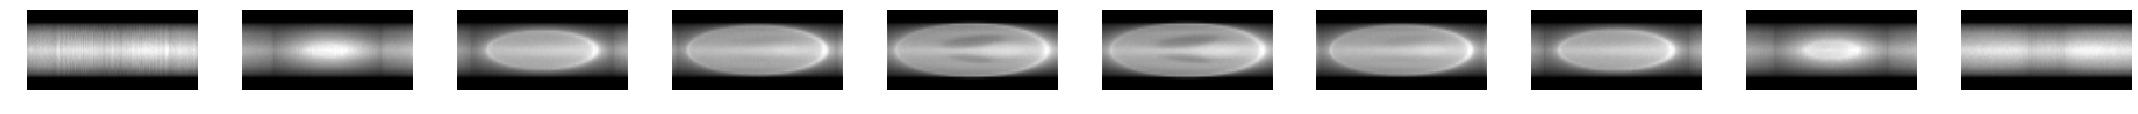

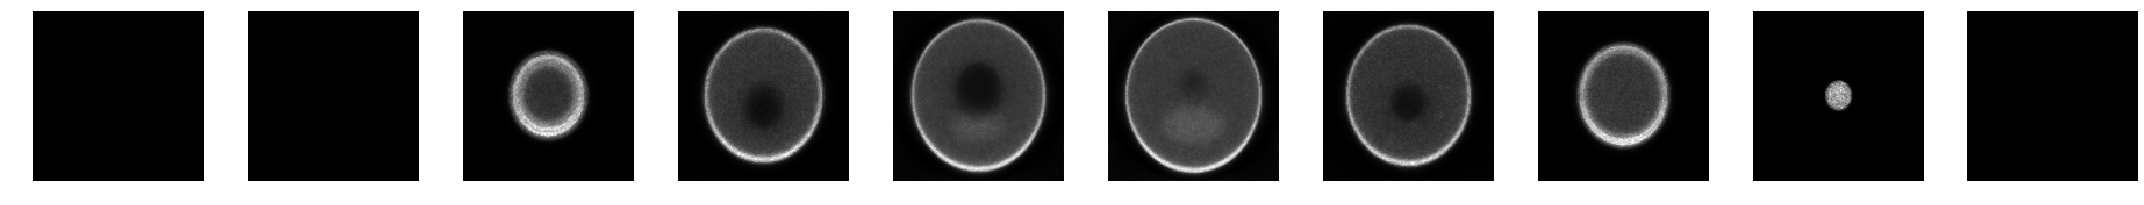

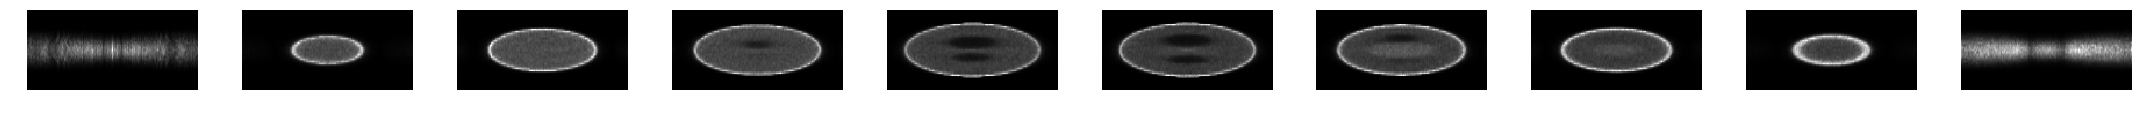

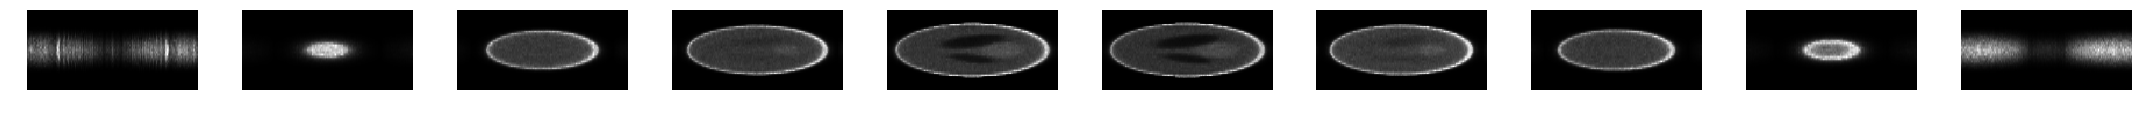

In [30]:
# RESULT VISUALIZATION

# MLEM RECONSTRUCTION WITH 1 ITERATION

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_1_shepp_logan[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_1_shepp_logan[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_1_shepp_logan[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()





# MLEM RECONSTRUCTION WITH 10 ITERATIONS

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=mlem_10_shepp_logan[num,0,ind,:,:].cpu()
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=mlem_10_shepp_logan[num,0,:,ind,:].cpu()
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=mlem_10_shepp_logan[num,0,:,:,ind].cpu()
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


In [33]:
# Introduce 1 iteration MLEM reconstruction of Shepp-Logan as input for the 3D denoising network
denoise_shepp_logan=denoise_net(mlem_1_shepp_logan.float().cuda())

/opt/tljh/user/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [35]:
# Adequate data to display results

denoise_shepp_logan=denoise_shepp_logan.cpu().detach().numpy()

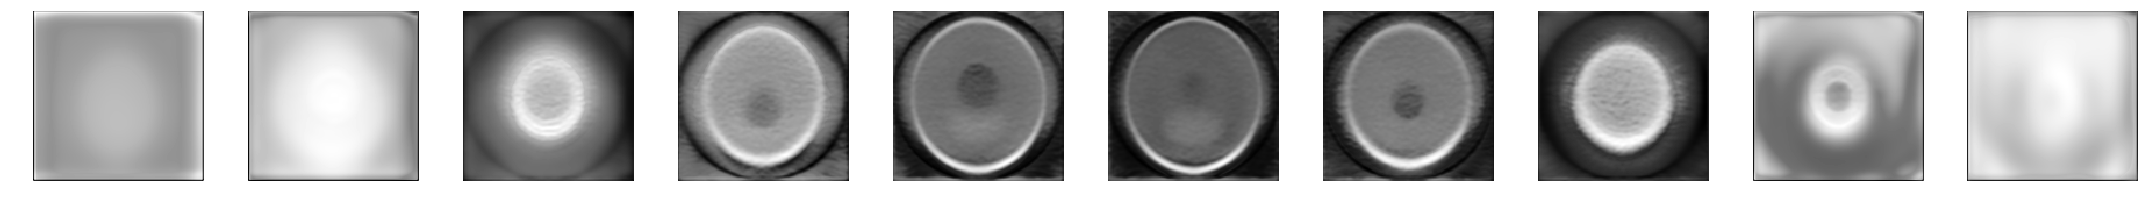

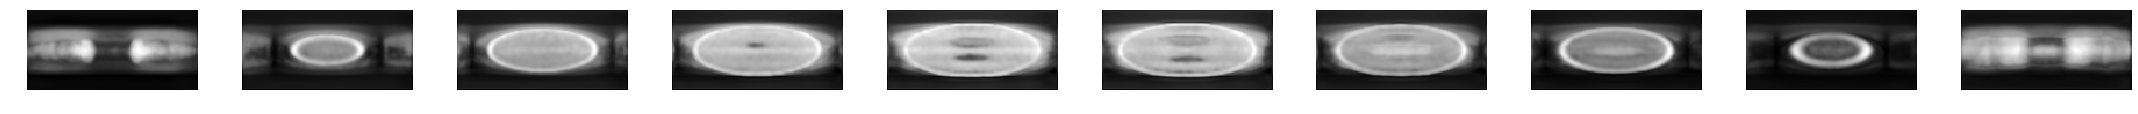

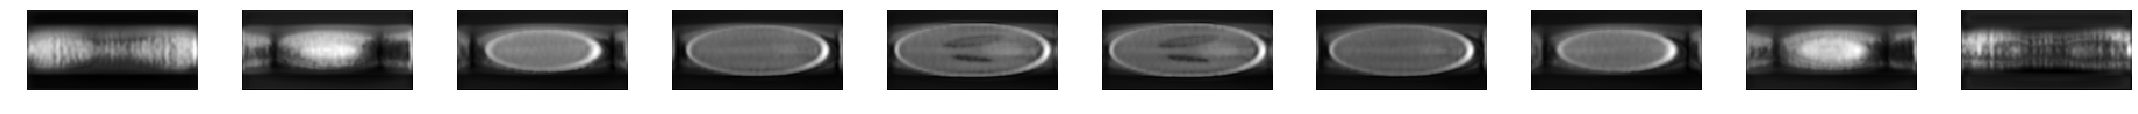

In [37]:
# VISUALIZATION OF DENOISING RESULTS FOR SHEPP-LOGAN

# Axial slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[2]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    axial_slice=denoise_shepp_logan[num,0,ind,:,:]
    axes[cont].imshow(axial_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()


# Coronal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[3]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    coronal_slice=denoise_shepp_logan[num,0,:,ind,:]
    axes[cont].imshow(coronal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()
 
# Sagittal slices
fig, axes=plt.subplots(nrows=1,ncols=10,figsize=(30,40))
slice_indexes=np.linspace(0,sz[4]-2,10).astype(int)
fig.tight_layout()
cont=0
for ind in slice_indexes:
    sagittal_slice=denoise_shepp_logan[num,0,:,:,ind]
    axes[cont].imshow(sagittal_slice,cmap='gray')
    axes[cont].axis('off')
    cont+=1

plt.show()

In [79]:
torch.save(denoise_net,'3d_denoise.torch')

/opt/tljh/user/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
